In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv(r"C:\Users\berid\python\avocado\avocado.csv")

In [4]:
df=df.drop(columns='Unnamed: 0')

In [5]:
df.sample()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
8731,2018-03-18,1.17,311526.49,76056.35,92588.91,7007.47,135873.76,80016.52,55393.91,463.33,conventional,2018,LasVegas


In [6]:
df['Date']=pd.to_datetime(df['Date'])

In [7]:
df['Month']=df['Date'].dt.month

In [8]:
df.sample()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,Month
4446,2016-06-26,1.18,333568.95,143186.79,76177.69,94.86,114109.61,68453.99,35165.62,10490.0,conventional,2016,Orlando,6


In [9]:
for col in df.select_dtypes('object').columns:
    print(col,df[col].nunique())

type 2
region 54


# REMOVING OUTLIERS 

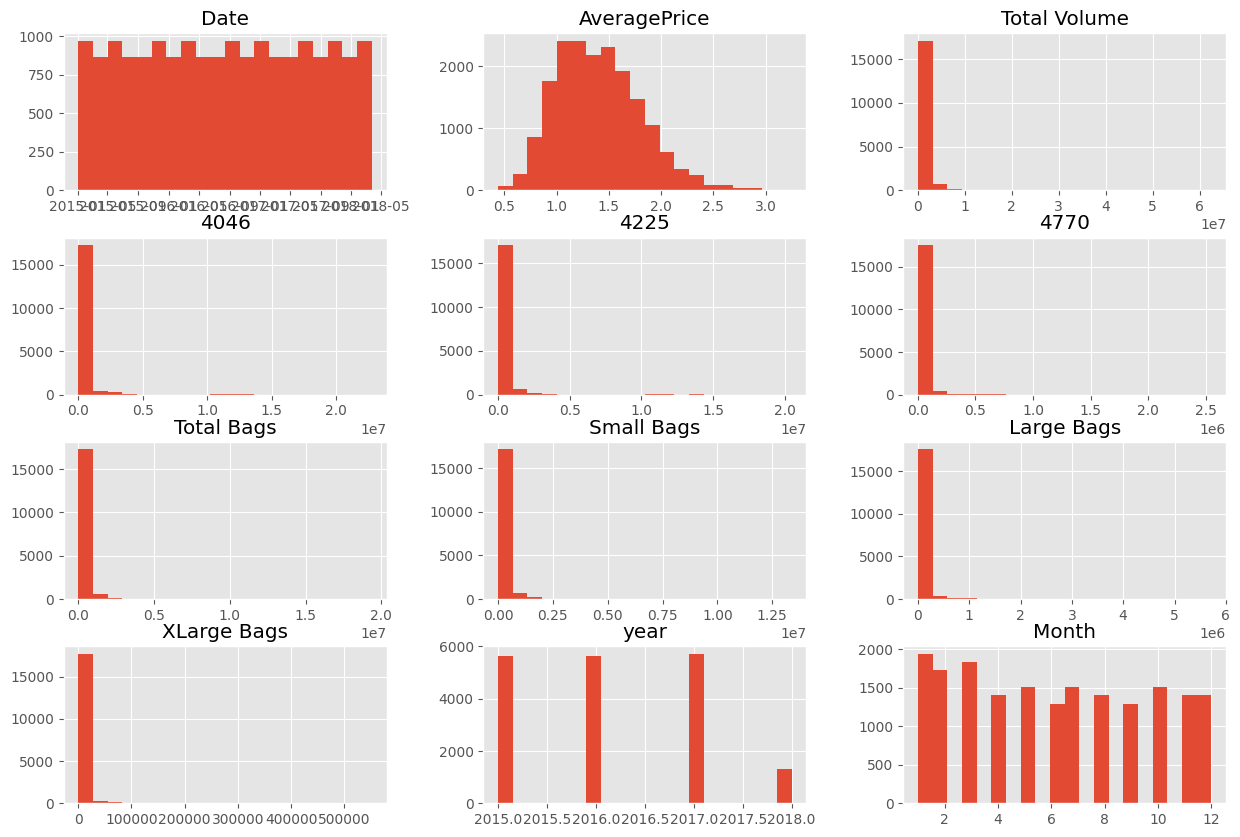

In [10]:
fig,ax=plt.subplots(figsize=(15,10))
df.hist(bins=20,ax=ax)
ax.set_yscale('log')
plt.show()

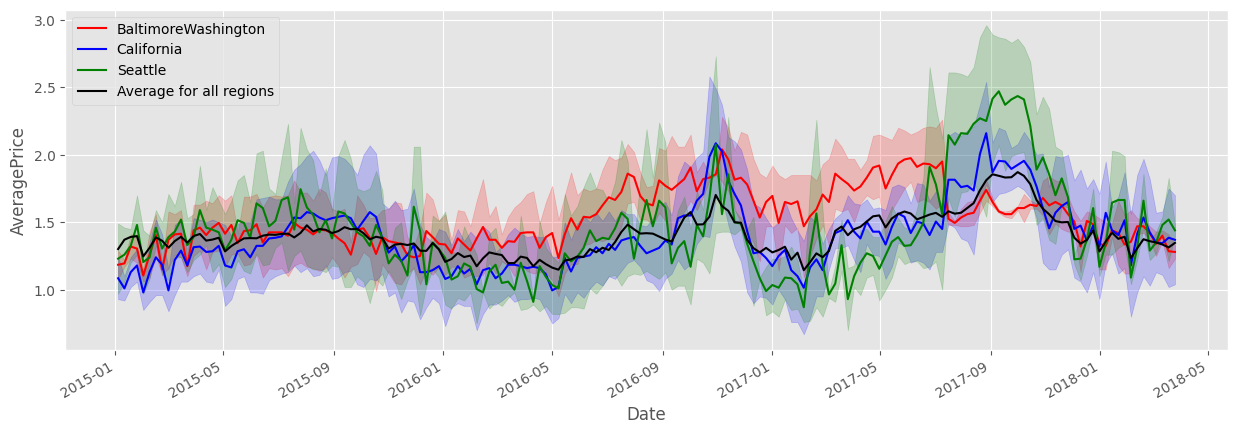

CPU times: total: 35 s
Wall time: 41 s


In [11]:
%%time
random=df['region'].sample(3)
sample=df[df['region'].isin(random)]

plt.figure(figsize=(15,5))
ax=sns.lineplot(sample,x='Date',y='AveragePrice',hue='region',palette=['red','blue','green'])
df.groupby('Date')['AveragePrice'].mean().plot(ax=ax,label='Average for all regions',color='black')
plt.legend()
plt.show()

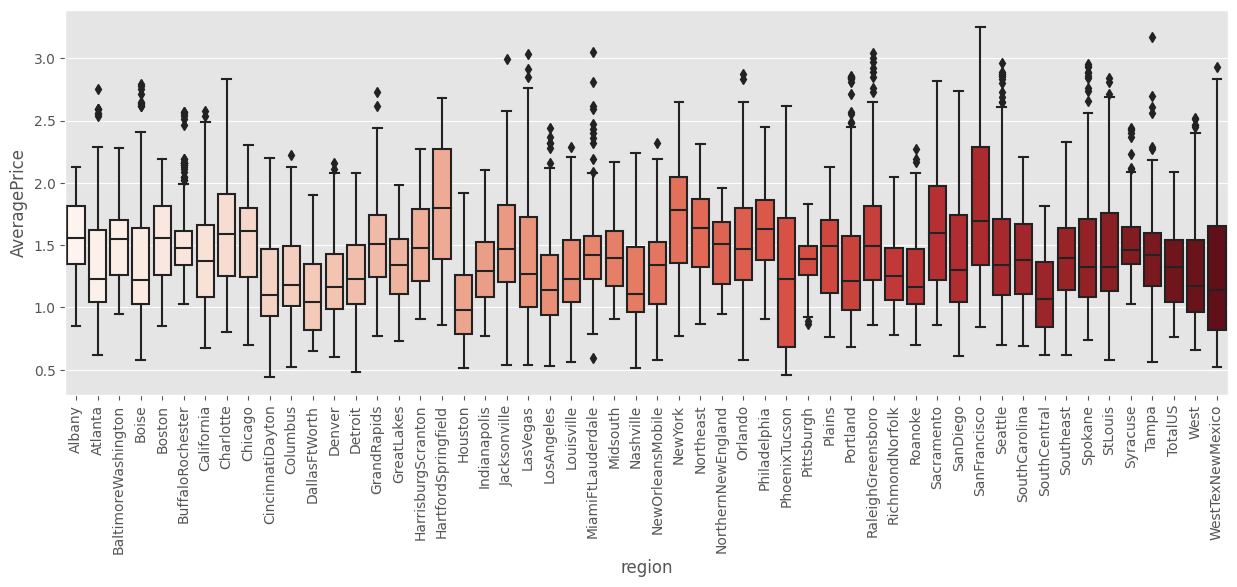

In [12]:
plt.figure(figsize=(15,5))
sns.boxplot(df,x='region',y='AveragePrice',palette='Reds')
plt.xticks(ticks=range(df['region'].nunique()),labels=df['region'].unique(),rotation=90)
plt.show()

In [13]:
df.corr()['AveragePrice'].sort_values(ascending=False)

AveragePrice    1.000000
Month           0.162409
year            0.093197
XLarge Bags    -0.117592
4225           -0.172928
Large Bags     -0.172940
Small Bags     -0.174730
Total Bags     -0.177088
4770           -0.179446
Total Volume   -0.192752
4046           -0.208317
Name: AveragePrice, dtype: float64

In [14]:
original=df.copy()

In [15]:
for col in df.select_dtypes('object').columns:
    dummies=pd.get_dummies(df[col],prefix=col,dummy_na=False)
    df=df.drop(columns=col)
    df=pd.concat([df,dummies],axis=1)

In [16]:
df=df.drop(columns='Date')

In [17]:
X=df.drop(columns='AveragePrice')
Y=df['AveragePrice']

from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest=train_test_split(X,Y,test_size=0.2)

In [18]:
from xgboost import XGBRegressor
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
model=XGBRegressor()
params={ 'learning_rate':[0.01,0.02,0.05], 'max_depth':[2,3,7], 'n_estimators':[200,500,1000] }
gs=GridSearchCV(model,params,n_jobs=1,verbose=10,cv=3)
gs.fit(xtrain,ytrain)

In [19]:
model=XGBRegressor(max_depth=6,n_estimators=1000,learning_rate=0.1)#max_depth=6,n_estimators=1000,learning_rate=0.1

In [20]:
model.fit(xtrain,ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [21]:
train_prediction=model.predict(xtrain)
test_prediction=model.predict(xtest)

In [22]:
r2_train=metrics.r2_score(train_prediction,ytrain)
r2_test=metrics.r2_score(test_prediction,ytest)
mae_train=metrics.mean_absolute_error(train_prediction,ytrain)
mae_test=metrics.mean_absolute_error(test_prediction,ytest)
rmse_train=metrics.mean_squared_error(train_prediction,ytrain,squared=False)
rmse_test=metrics.mean_squared_error(test_prediction,ytest,squared=False)
print('R2, MAE ,RMSE for train and test data are:')
print(r2_train,r2_test)
print(mae_train,mae_test)
print(rmse_train,rmse_test)

R2, MAE ,RMSE for train and test data are:
0.9885138233280987 0.9195121082543284
0.030143010772836643 0.07708405151922408
0.04227573567379589 0.10869314277183556


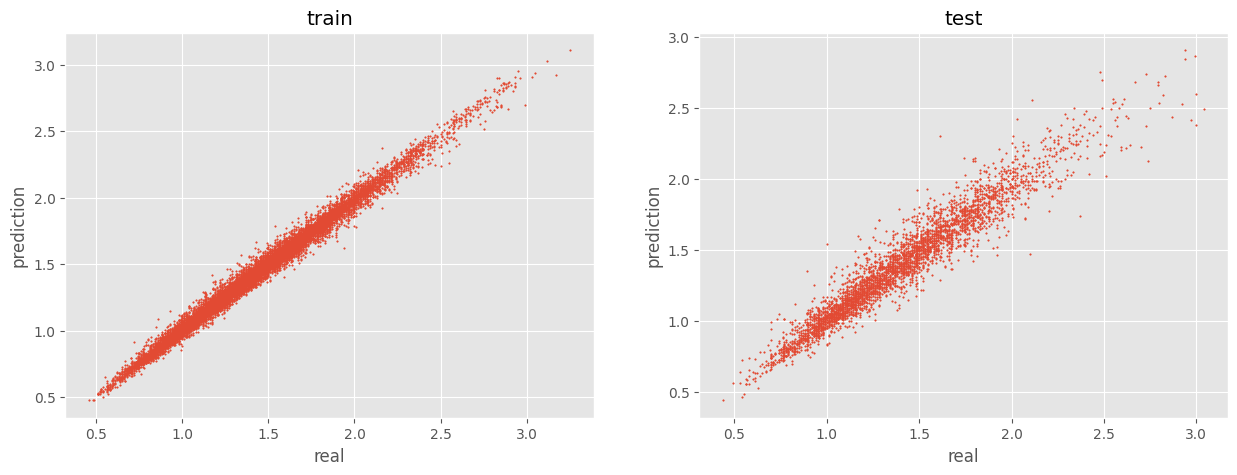

In [23]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.scatter(ytrain,train_prediction,s=1)
ax1.set_xlabel('real')
ax1.set_ylabel('prediction')
ax1.set_title('train')
ax2.scatter(ytest,test_prediction,s=1)
ax2.set_xlabel('real')
ax2.set_ylabel('prediction')
ax2.set_title('test')
plt.show()

# CHECKING

In [24]:
xtest['Real']=ytest
xtest['Prediction']=test_prediction

In [25]:
original=original.merge(xtest[['Real','Prediction']],left_index=True,right_index=True)

In [26]:
original['Residue']=(original['Real']-original['Prediction']).abs()

In [27]:
original=original.sort_values(by='Residue',ascending=False)

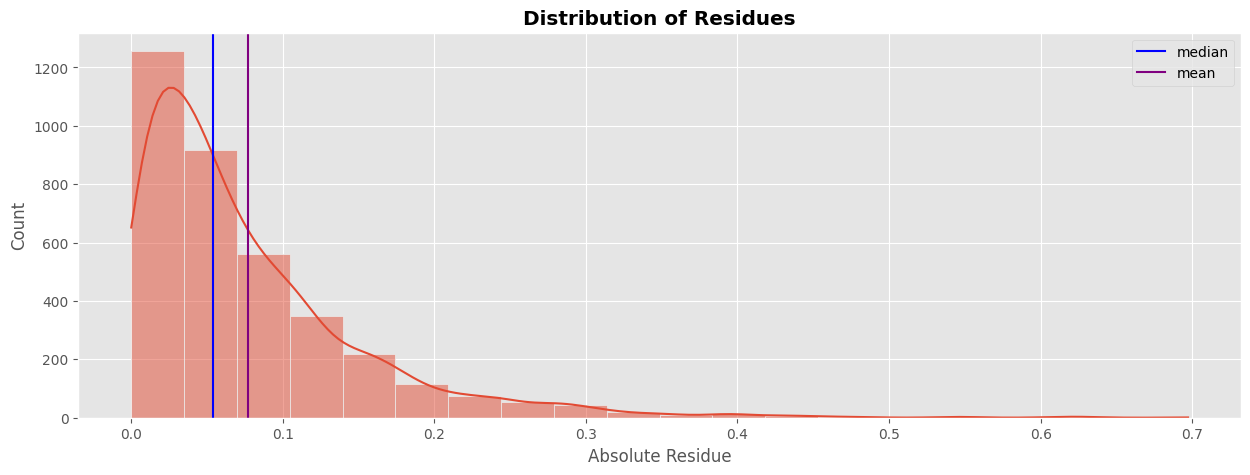

In [28]:
plt.figure(figsize=(15,5))
sns.histplot(original['Residue'],bins=20,kde=True)
plt.axvline(original['Residue'].median(),color='blue',label='median')
plt.axvline(original['Residue'].mean(),color='purple',label='mean')
plt.title('Distribution of Residues',fontweight='bold')
plt.xlabel('Absolute Residue')
plt.legend()
plt.show()

In [29]:
cols=[]
for col in original.columns:
    if original[col].nunique()<60:
        cols.append(col)

In [30]:
cols

['type', 'year', 'region', 'Month']

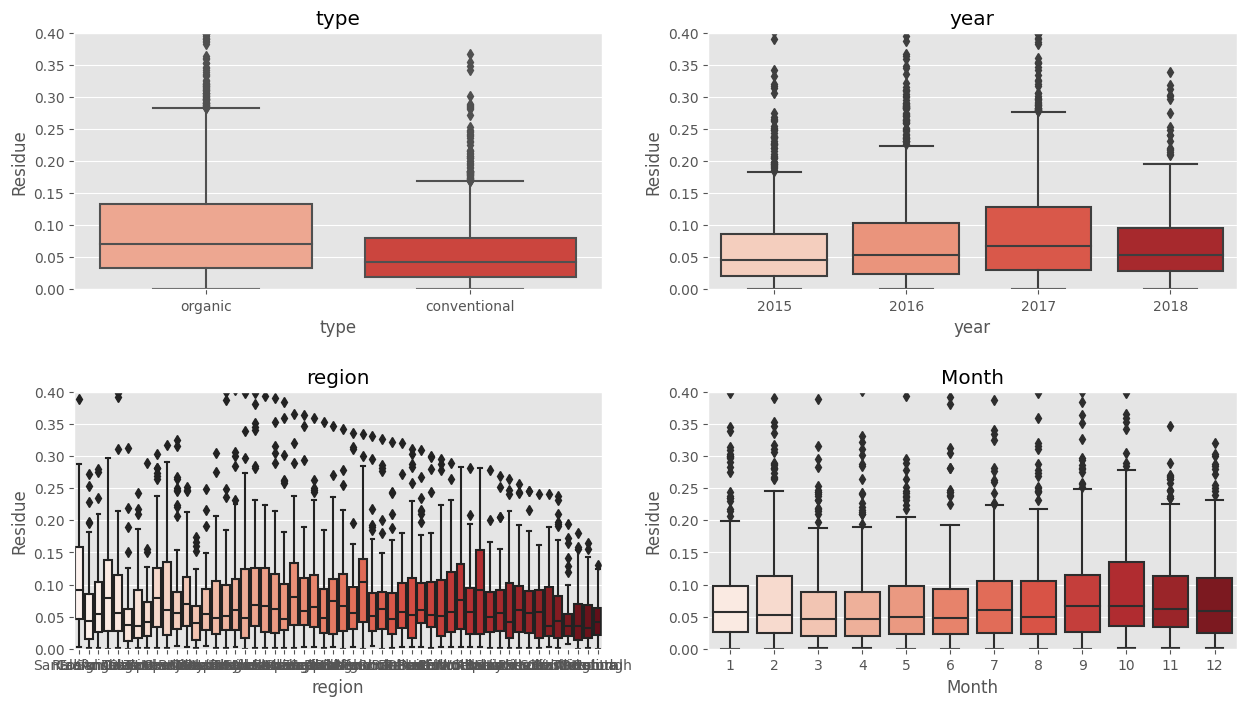

In [31]:
fig,axes=plt.subplots(2,2,figsize=(15,8))

for col,ax in zip(cols,axes.ravel()):
    #grouped=original.groupby(col)['Residue'].mean().reset_index().sort_values('Residue',ascending=False)
    #grouped.plot(ax=ax,kind='bar',x=col,y='Residue')
    sns.boxplot(original,x=col,y='Residue',ax=ax,palette='Reds')
    ax.set_title(col)
    ax.set_ylim(0,0.4)
plt.subplots_adjust(hspace=0.4)
plt.show()

In [32]:
cols=[]
for col in original.columns:
    if original[col].nunique()>60:
        cols.append(col)
        
cols=cols[0:-3]

In [33]:
cols

['Date',
 'AveragePrice',
 'Total Volume',
 '4046',
 '4225',
 '4770',
 'Total Bags',
 'Small Bags',
 'Large Bags',
 'XLarge Bags']

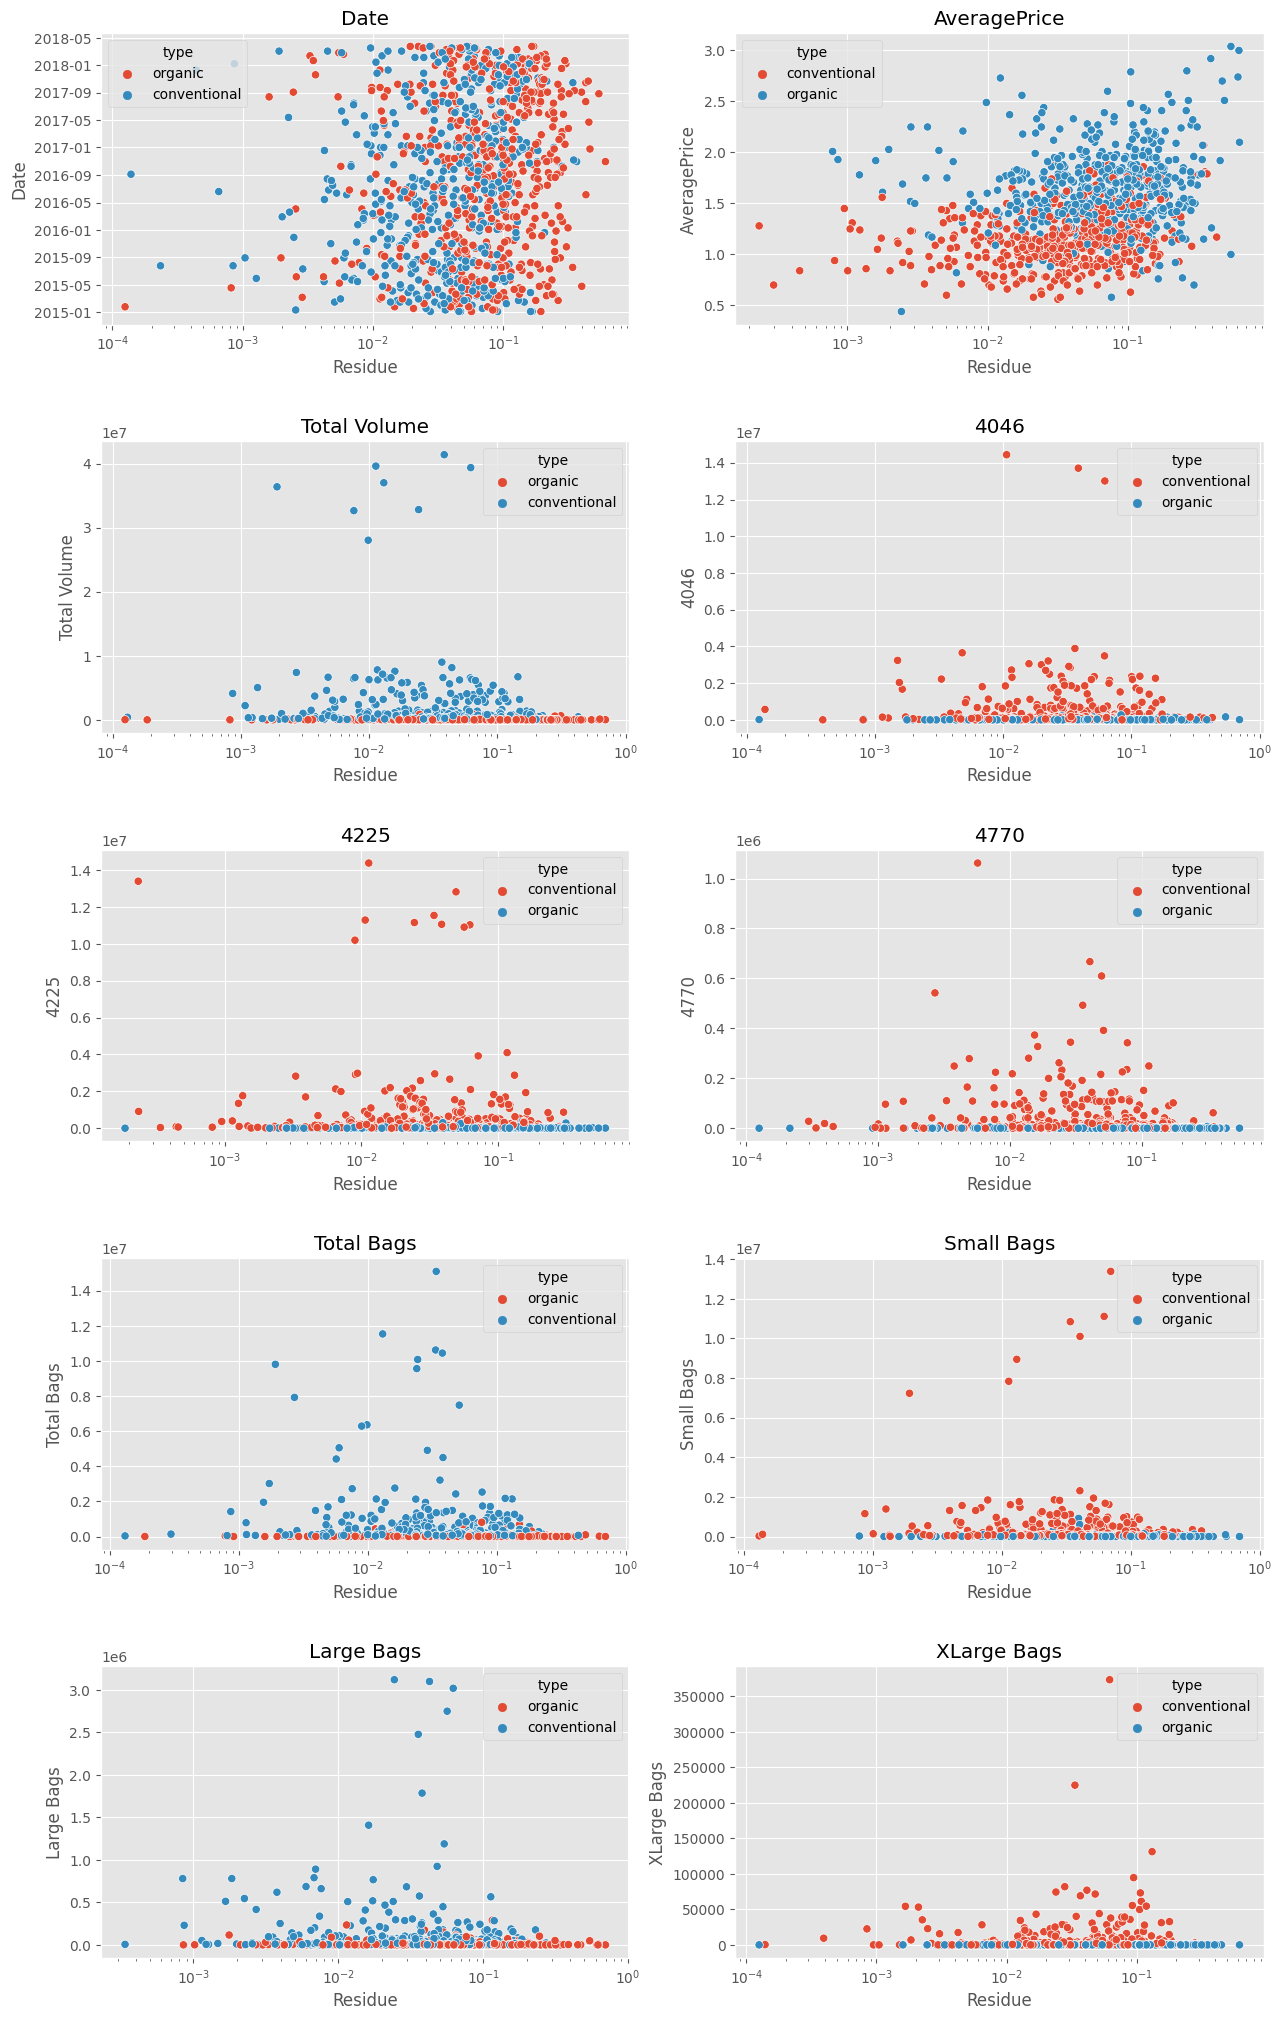

CPU times: total: 8.39 s
Wall time: 9.51 s


In [34]:
%%time
fig,axes=plt.subplots(5,2,figsize=(15,25))
for col,ax in zip(cols,axes.ravel()):
    #sns.kdeplot(original.sample(10**3),y=col,x='Residue',ax=ax,levels=20,fill=True)
    sns.scatterplot(original.sample(10**3),y=col,x='Residue',ax=ax,hue='type')
    ax.set_title(col)
    #ax.set_yscale('log')
    ax.set_xscale('log')
plt.subplots_adjust(hspace=0.4)    
plt.show()

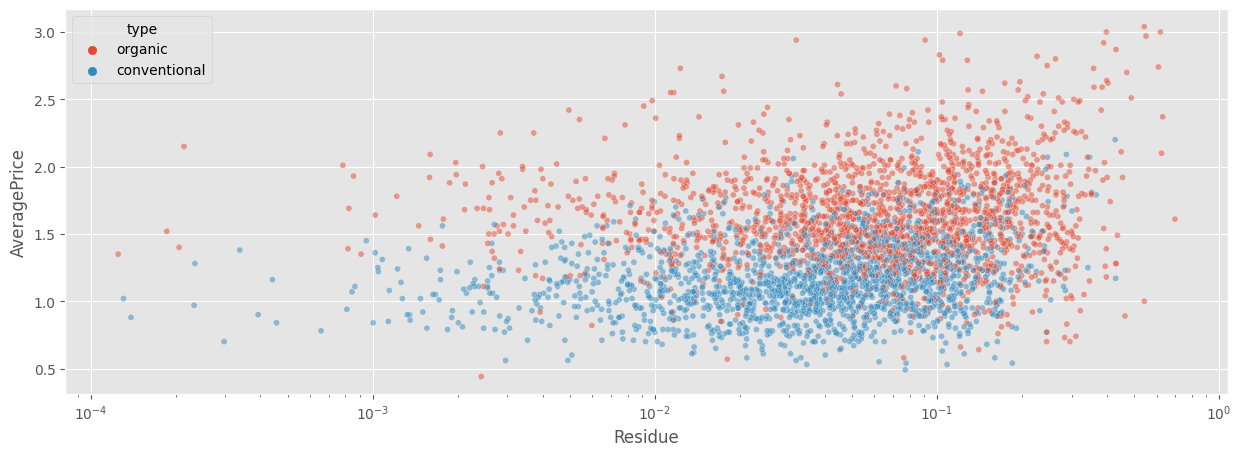

In [35]:
fig,ax=plt.subplots(figsize=(15,5))
sns.scatterplot(original,y='AveragePrice',x='Residue',s=20,hue='type',ax=ax,alpha=.5)#[original['type']=='organic']
ax.set_xscale('log')
#ax.set_yscale('log')

In [36]:
# when real prices of organic avocados are getting high, than the model struggles to predict precisely and residue value increases

<AxesSubplot: xlabel='type', ylabel='Residue'>

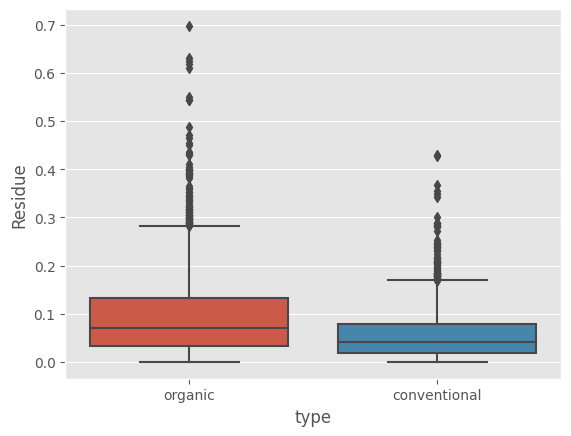

In [37]:
sns.boxplot(original,x='type',y='Residue')